<a href="https://colab.research.google.com/github/RiniVarghese/CNN_Assignment/blob/Master/CNN_Melonona_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early.

**Steps Followed**

1.   Data Reading/Data Understanding
2.   Dataset Creation
3.   Dataset visualisation
4.   Model Building & training
5.   data augmentation strategy
6.   Model Building & training on the augmented data
7.   Class distribution:
8.   Handling class imbalances
9.   Model Building & training on the rectified class imbalance data







In [1]:
import pathlib
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

# Data Reading/Data Understanding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(tf.__version__)

2.12.0


In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")


In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t",image_count_test)

Train images:	 2239
Test images:	 118


# Dataset Creation

 Load using keras.preprocessing.

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [4]:
# Defining Parameters
batch_size = 32
img_height = 180
img_width = 180

In [5]:
### Training Dataset
train_ds= tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset = 'training',
    seed =123,
    image_size=(img_height,img_width),
    batch_size= batch_size)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
### Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Data Visualization

Found 2239 files belonging to 9 classes.


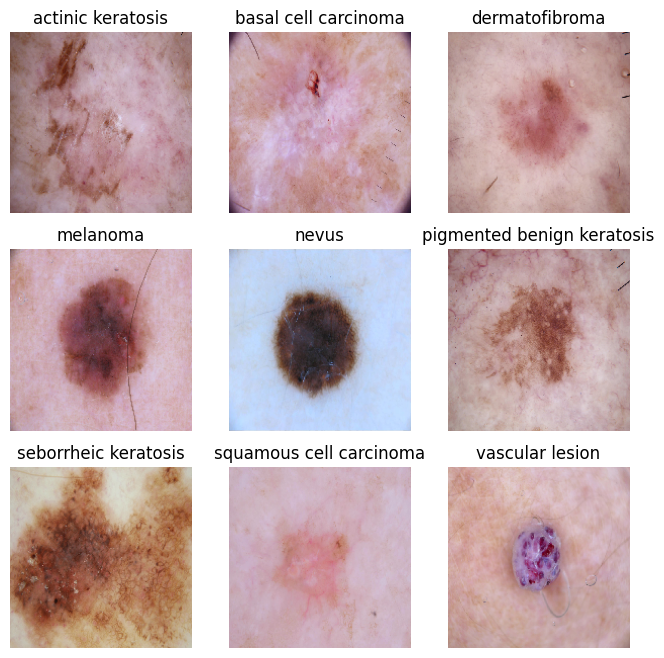

In [8]:
#Visualize one instance of all the class present in the dataset

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(8,8))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

# Class distribution  

checking the Class distirbution before proceeding further with Model building

In [9]:
def class_distribution_count(directory):
    # Create a Path object for the input directory
    directory_path = Path(directory)

    # Use list comprehension to count the number of images in each class
    count = [len(list(path.glob('*'))) for path in directory_path.iterdir() if path.is_dir()]

    # Get the names of the classes
    sub_directory = [path.name for path in directory_path.iterdir() if path.is_dir()]

    # Create a DataFrame with image count and class
    df = pd.DataFrame({'Class': sub_directory, 'No. of Image': count})

    return df

df = class_distribution_count(data_dir_train)
print(df)


                        Class  No. of Image
0        seborrheic keratosis            77
1        basal cell carcinoma           376
2           actinic keratosis           114
3                    melanoma           438
4              dermatofibroma            95
5             vascular lesion           139
6                       nevus           357
7     squamous cell carcinoma           181
8  pigmented benign keratosis           462


<Axes: xlabel='No. of Image', ylabel='Class'>

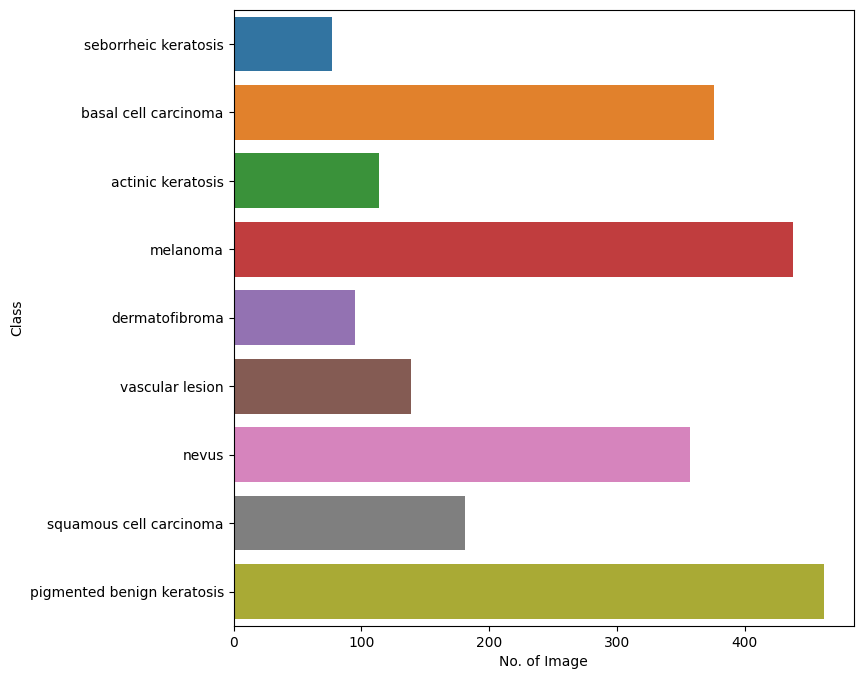

In [10]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There are 9 classes present in the dataset and it a highly imbalanced Dataset

Which class has the least number of samples?

   - seborrheic keratosis had only 77 samples

Which classes dominate the data in terms of the proportionate number of
samples
 - pigmented benign keratosis - 462
 - melanoma  - 438
 - nevus     - 357
 - basal cell carcinoma - 376

# Model Building

Model 1

In [11]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Compile the Model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

# Train the Model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 345s 1s/step - loss: 2.1918 - accuracy: 0.1908 - val_loss: 1.8845 - val_accuracy: 0.3356
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.7704 - accuracy: 0.3488 - val_loss: 1.6087 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 2s 36ms/step - loss: 1.4911 - accuracy: 0.4676 - val_loss: 1.3992 - val_accuracy: 0.5280
Epoch 4/20
56/56 [==============================] - 2s 36ms/step - loss: 1.3544 - accuracy: 0.5201 - val_loss: 1.4080 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2451 - accuracy: 0.5686 - val_loss: 1.4090 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 2s 37ms/step - loss: 1.1883 - accuracy: 0.5871 - val_loss: 1.6212 - val_accuracy: 0.4676
Epoch 7/20
56/56 [==============================] - 2s 36ms/step - loss: 1.1893 - accuracy: 0.5792 - val_loss: 1.4179 - val_accuracy: 0.5280
Epoch 8/20
56/56 [======

In the first Model created we have accuracy for training dataset as 85% and the accuracy for test dataset - 55% only

### Visualizing the training results

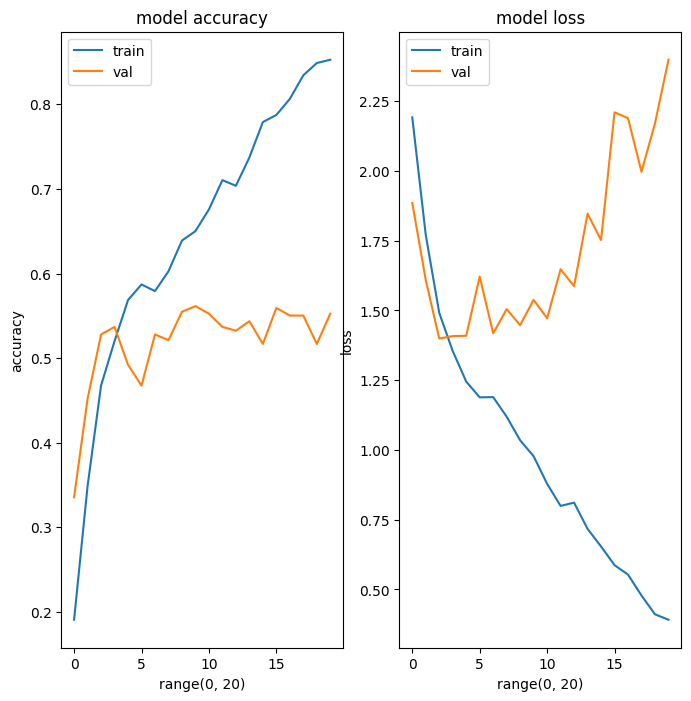

In [15]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

##Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')


##Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


This is overfitted model with the accuracy for training set is very high and accuracy is low for the validation dataset

# Data Agumentation

Data Augmentation  to reduce the overfitting problem


In [16]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

Visualize the Augumented Data

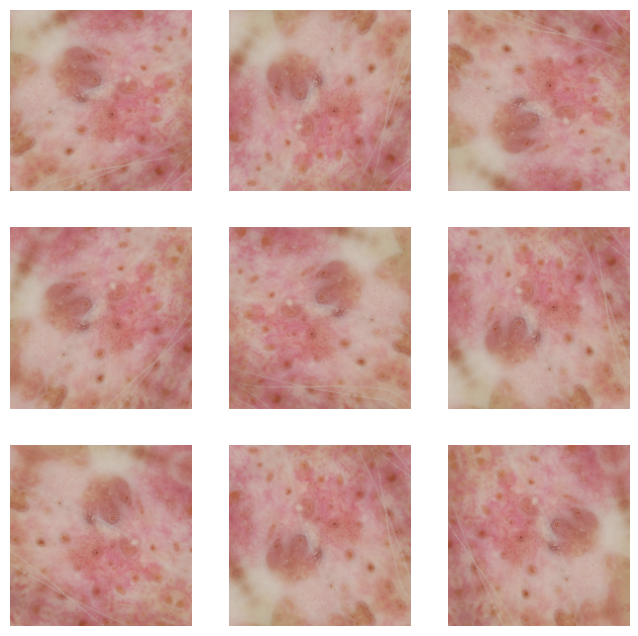

In [17]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)
plt.figure(figsize=(8, 8))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)
  plt.imshow((augmented_image1))
  plt.axis("off")

Model Building & training on the augmented data

MODEL 2

In [30]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding ='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


Compile the Model

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                 

In [33]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 5s 59ms/step - loss: 2.0540 - accuracy: 0.2427 - val_loss: 1.8690 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 3s 58ms/step - loss: 1.8094 - accuracy: 0.3482 - val_loss: 1.7133 - val_accuracy: 0.3647
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 1.6294 - accuracy: 0.4118 - val_loss: 1.5123 - val_accuracy: 0.4519
Epoch 4/20
56/56 [==============================] - 3s 56ms/step - loss: 1.4973 - accuracy: 0.4715 - val_loss: 1.5710 - val_accuracy: 0.4430
Epoch 5/20
56/56 [==============================] - 3s 60ms/step - loss: 1.4834 - accuracy: 0.4632 - val_loss: 1.5209 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 3s 56ms/step - loss: 1.4232 - accuracy: 0.5028 - val_loss: 1.3704 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 3s 59ms/step - loss: 1.4087 - accuracy: 0.5106 - val_loss: 1.3713 - val_accuracy: 0.5101
Epoch 8/20
56/56 [======

Observation -
After applying data augmentation we see that the overfitting has reduced the training accuracy is 57% and test accuracy is 51%
We need to resolve the Class Imbalance to get better accuracy

Checking for Class Imbalance

In [34]:
df = class_distribution_count(data_dir_train)
print(df)

                        Class  No. of Image
0        seborrheic keratosis            77
1        basal cell carcinoma           376
2           actinic keratosis           114
3                    melanoma           438
4              dermatofibroma            95
5             vascular lesion           139
6                       nevus           357
7     squamous cell carcinoma           181
8  pigmented benign keratosis           462


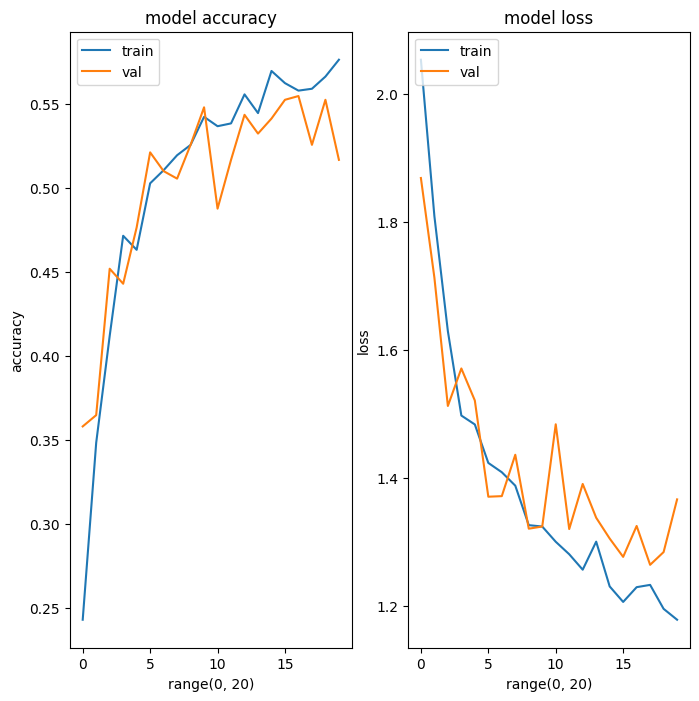

In [35]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

##Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')


##Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Overfitting had reduced a lost from the earlier runs. We can further check after Augementing the dataset

**Handling class imbalances:**

Rectify class imbalances present in the training dataset with Augmentor library

In [36]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [37]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/CNN Assignment/Skin can...,seborrheic keratosis
1,/content/drive/MyDrive/CNN Assignment/Skin can...,seborrheic keratosis
2,/content/drive/MyDrive/CNN Assignment/Skin can...,seborrheic keratosis
3,/content/drive/MyDrive/CNN Assignment/Skin can...,seborrheic keratosis
4,/content/drive/MyDrive/CNN Assignment/Skin can...,seborrheic keratosis
...,...,...
2234,/content/drive/MyDrive/CNN Assignment/Skin can...,pigmented benign keratosis
2235,/content/drive/MyDrive/CNN Assignment/Skin can...,pigmented benign keratosis
2236,/content/drive/MyDrive/CNN Assignment/Skin can...,pigmented benign keratosis
2237,/content/drive/MyDrive/CNN Assignment/Skin can...,pigmented benign keratosis


Using Augmentor for Class Imbalance Treatment

In [38]:
#install Augmentor
!pip install Augmentor

In [39]:
path_to_training_dataset="/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
path_str = str(path_to_training_dataset)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_str + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2B20FB4610>: 100%|██████████| 500/500 [00:19<00:00, 25.81 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C2B20E23CD0>: 100%|██████████| 500/500 [00:22<00:00, 22.07 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2B17EA77C0>: 100%|██████████| 500/500 [00:21<00:00, 23.15 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C2B13315B70>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7C2B16CF34F0>: 100%|██████████| 500/500 [01:14<00:00,  6.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2BA1D3ACB0>: 100%|██████████| 500/500 [00:16<00:00, 30.45 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C2B17F32170>: 100%|██████████| 500/500 [00:39<00:00, 12.82 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2C5AC8A140>: 100%|██████████| 500/500 [00:16<00:00, 30.56 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C2B2025FC10>: 100%|██████████| 500/500 [00:17<00:00, 29.03 Samples/s]


In [40]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [41]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [43]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df['Label'].value_counts()

<ipython-input-43-9b90e69faf49>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

We  have added images with Augmentor in each class improved the class balance


# Model Building & training on the rectified class imbalance data

In [44]:
# train dataset
train_ds= tf.keras.utils.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset = 'training',
                                                      seed =123,image_size=(img_height,img_width),batch_size= batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [45]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [46]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [50]:
#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding ='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding ='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding ='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

###### Compile the Model

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 45, 45, 128)      

In [53]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 46s 98ms/step - loss: 1.9120 - accuracy: 0.2782 - val_loss: 1.5646 - val_accuracy: 0.4016
Epoch 2/30
169/169 [==============================] - 9s 53ms/step - loss: 1.4866 - accuracy: 0.4234 - val_loss: 1.3992 - val_accuracy: 0.4759
Epoch 3/30
169/169 [==============================] - 9s 53ms/step - loss: 1.3903 - accuracy: 0.4811 - val_loss: 1.2515 - val_accuracy: 0.5509
Epoch 4/30
169/169 [==============================] - 9s 51ms/step - loss: 1.2444 - accuracy: 0.5371 - val_loss: 1.0791 - val_accuracy: 0.5999
Epoch 5/30
169/169 [==============================] - 9s 52ms/step - loss: 1.1083 - accuracy: 0.5896 - val_loss: 0.9864 - val_accuracy: 0.6251
Epoch 6/30
169/169 [==============================] - 9s 52ms/step - loss: 0.9917 - accuracy: 0.6348 - val_loss: 0.9353 - val_accuracy: 0.6526
Epoch 7/30
169/169 [==============================] - 9s 53ms/step - loss: 0.8806 - accuracy: 0.6775 - val_loss: 0.8690 - val_accuracy: 0.6941
Epoch 8/3

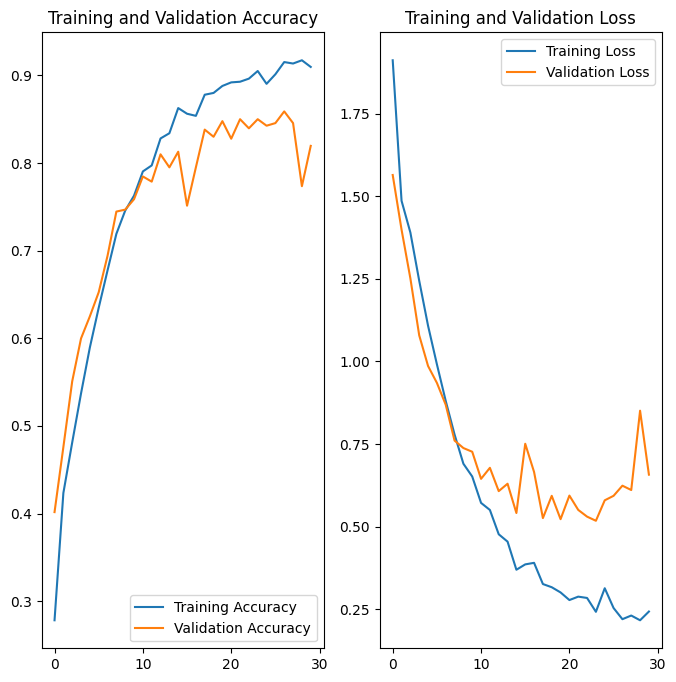

In [54]:
# Visualizing the model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After rebalancing the class we see the accuracy of the training is now 90% and Validation is 81%

Model Prediction

1/1 [==============================] - 0s 254ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


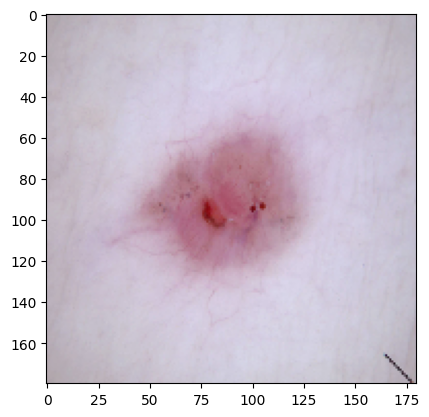

In [55]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

Final Conclusion

*   We see that the model is predicting correctly.
*   The accuracy of the Training and Validation set have improved
*   Overfitting issue also got resolved after applying the Augmentor
*   












